<a href="https://colab.research.google.com/github/NAVEED261/MY-AI-ASSISTANT/blob/main/filter_msg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_google_genai

In [14]:
from google.colab import userdata
import os
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
from google.colab import userdata
langchainY = userdata.get('langchain')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchai"

# Filtering aur Trimming Messages
# Review
Ab hum kuch cheezon ko gehri tarah samajh gaye hain:

Graph state schema ko customize karna kaise hota hai.
Custom state reducers ko kaise define kiya jata hai.
Multiple graph state schemas kaise istemal hote hain.
# ***Goals***
Ab hum in concepts ko LangGraph models ke saath istemal karna shuru kar sakte hain!

Agle kuch sessions mein, hum ek long-term memory wala chatbot banayenge.

Kyunkay hamara chatbot messages ka istemal karega, pehle hum graph state mein messages ke saath kaam karne ke advanced tareeqon par baat karte hain.








In [15]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    google_api_key=GOOGLE_API_KEY # Changed to use the variable instead of the string.
)

In [16]:
llm.invoke("assalamualykum")

AIMessage(content='Wa alaikum assalam!\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-f3574e5f-6cf2-4dd9-bb71-823f32e5f6e7-0', usage_metadata={'input_tokens': 6, 'output_tokens': 7, 'total_tokens': 13, 'input_token_details': {'cache_read': 0}})

In [18]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langgraph.graph.state import CompiledStateGraph


# ***Reducer***
Messages ke saath kaam karte waqt ek practical challenge hoti hai long-running conversations ko manage karna.

Long-running conversations ka nateeja high token usage aur latency ki surat mein nikalta hai agar hum dhyan na dein, kyunke hum model ko barhte huye messages ki list pass karte rehte hain.

Is problem ko solve karne ke liye humare paas kuch tareeqe hain.

Sabse pehle, woh trick yaad karein jo humne RemoveMessage aur add_messages reducer ke saath dekhi thi.

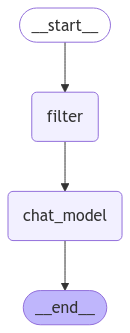

In [50]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState) -> MessagesState:
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState) -> MessagesState:
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder: StateGraph = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph: CompiledStateGraph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [51]:
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage("Hi how r u?.", name="Bot", id="1")]
messages.append(HumanMessage("im fine thank u and u .", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great you're interested in ocean mammals!  Whales are a big group, but there's a whole fascinating world beyond them.  Here are some other groups of ocean mammals you should learn about, categorized for easier understanding:

**1. Seals, Sea Lions, and Walruses (Pinnipeds):**

* **Seals:**  Generally smaller, lack external ear flaps (pinnae), and have streamlined bodies for efficient swimming.  There are many species with diverse adaptations.  Learn about harbor seals, elephant seals, leopard seals, etc.  Consider their different hunting strategies and social behaviors.
* **Sea Lions:** Larger than most se

In [23]:
async for m in graph.astream_events({'messages': messages}, version="v2"): # The version argument is now correctly passed as a keyword argument.
      print(m)
      print("\n--------------\n")

{'event': 'on_chain_start', 'data': {'input': {'messages': [AIMessage(content='Hi how r u?.', additional_kwargs={}, response_metadata={}, name='Bot', id='1'), HumanMessage(content='im fine thank u and u .', additional_kwargs={}, response_metadata={}, name='Lance', id='2'), AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='3'), HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='4')]}}, 'name': 'LangGraph', 'tags': [], 'run_id': '95e5f8c3-e98d-4ec4-b67e-e2b3654a4328', 'metadata': {}, 'parent_ids': []}

--------------

{'event': 'on_chain_start', 'data': {'input': {'messages': [AIMessage(content='Hi how r u?.', additional_kwargs={}, response_metadata={}, name='Bot', id='1'), HumanMessage(content='im fine thank u and u .', additional_kwargs={}, response_metadata={}, name='Lance', id='2'), AIMessage(content='So you 

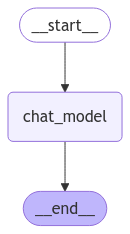

In [35]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-2:])]}

# Build graph
builder: StateGraph = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph: CompiledStateGraph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [37]:
messages.append(output['messages'][-2:])
messages = [AIMessage("Hi.how r u", name="Bot", id="1")]
messages.append(HumanMessage("im fine thank u and u.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.how r u
================================ Human Message =================================
Name: Lance

im fine thank u and u.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?


In [38]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.how r u
================================ Human Message =================================
Name: Lance

im fine thank u and u.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great you're interested in ocean mammals! Whales are a fantastic starting point, but the ocean holds a whole lot more.  To broaden your research, consider these groups:

**1. Seals, Sea Lions, and Walruses (Pinnipeds):**  These are all closely related, but have distinct characteristics.  Learn about their different adaptations for swimming and hunting, their social structures, and their geo

note: hum jub ya wala method use karain ga to sara msg colab ms show houga but langsmit ki chathistroy ma wohi show jiska humna filter msg krta time slic use kya tha [-2:]

last and simple type of filter

In [45]:
from langchain_core.messages import AIMessage, HumanMessage

# Example Messages
messages = [
    AIMessage("So you said you were researching ocean mammals?", name="Bot"),
    HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance"),
    AIMessage("Whales are fascinating! You should also explore dolphins and seals.", name="Bot"),
    HumanMessage("Great! Tell me more about dolphins.", name="Lance")
]

# Function to filter messages
def filter_messages(messages, max_messages=2):
    """Filters the last `max_messages` from the list."""
    return messages[-1:]

# Filtered Messages
filtered = filter_messages(messages, max_messages=2)

# Display the filtered messages
for message in filtered:
    print(f"Name: {message.name}\nContent: {message.content}\n")


Name: Lance
Content: Great! Tell me more about dolphins.



# Trim messages
Ek aur approach hai messages ko trim karna, jo ek set number of tokens par mabni hoti hai.

Ye message history ko ek specified number of tokens tak restrict karta hai.

Jab ke filtering sirf agents ke darmiyan post-hoc subset messages ko return karti hai, trimming token ki ginti ko restrict karta hai jo chat model response dene ke liye istemal karta hai.

Niche trim_messages ka example dekhein.

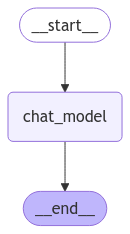

In [39]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=ChatGoogleGenerativeAI(model="gemini-1.5-flash"),
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [41]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))